# InvestBot: a bot for stock classification using fundamentalist analysis

InvestBot is a decision support tool for investors. It consists of classifying stocks on the stock exchange as a reliable investment or not to buy at that particular time, based on the following criteria:

- if the stock price will yield 3% or more until the next quarter

That is, a stock will be classified as reliable if it yields 3% or more. If the stock depreciates, or yield less than 3%, it will be classified as unreliable. 

**An important question is: how will we predict if a stock will appreciate until the next quarter?**

Basically, we will use a very famous approach in the investment world: fundamental analysis. This technique aims to determine the intrinsic value of a company, and its growth potential. For this, it uses some data that are called fundamental indicators, and these can be found from the balance sheet and income statement of companies.

With the data from the indicators collected, and the classes of stocks already defined, following the criteria explained above, some classification models will be trained, in order that they can predict whether a stock will appreciate more than 3% until the next quarter.

However, a doubt may arise: **fundamental analysis is used for medium and long-term investments, so is it possible to analyze the data of fundamental indicators to determine if a stock will appreciate until the next quarter? Well, that's what we'll find out at the end of this work.** As the fundamental analysis makes it possible to discover the real value of a stock, it may be possible from it to determine whether a stock will appreciate in value until the next quarter.

**The main objective here is to build a tool that supports investors' decision making for short-term investments, helping him to determine whether an action is reliable to buy at any given time.**

In the next sections, each of the steps necessary for us to reach the desired result will be developed.

## Solution Proposal

To solve the problem, we will follow these steps:

- **0.0.** Data Collection.
- **1.0.** Data Description.
- **2.0.** Feature Engineering
- **3.0.** Data Filtering
- **4.0.** Exploratory Data Analysis
- **5.0.** Data Preparation
- **6.0.** Feature Selection
- **7.0.** Machine Learning Modelling
- **8.0.** Hyperparameter Fine Tuning
- **9.0.** Machine Learning Performance
- **10.0.** Deploy Model to Production

<p align='center'>
    <img src='img/bot.jpg'>
</p>

# 0.0 Imports

In this section we will import the libraries needed to get the solution.

In [1]:
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import plotly.express              as px
import os
import pickle
from sklearn.preprocessing         import StandardScaler
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.model_selection       import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report, confusion_matrix, make_scorer, precision_score
from sklearn.metrics               import recall_score, accuracy_score, f1_score
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.neural_network        import MLPClassifier
from sklearn.ensemble              import RandomForestClassifier
from pandas_datareader             import data as web

import warnings
warnings.filterwarnings("ignore")

## 0.1. Helper Functions

in this step, we'll document all the functions that will be used to solve the problem.

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    #plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    #pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
def collect_balances( fundamentals, files, companies ):
    
    for file in files:
        # collecting only the company name
        name = file[:-4]

        # Balance Sheet
        balance = pd.read_excel( f'Balances/{file}', sheet_name=0 )

        # Name of the company as a title in the first column
        balance.iloc[0, 0] = name

        # Make the first line a header
        balance.columns = balance.iloc[0]
        balance = balance.iloc[1:]

        # Make the first column an index
        balance = balance.set_index( name )

        # Cash Flow Statement
        cfs = pd.read_excel( f'Balances/{file}', sheet_name=1 )

        # Name of the company as a title in the first column
        cfs.iloc[0, 0] = name

        # Make the first line a header
        cfs.columns = cfs.iloc[0]
        cfs = cfs.iloc[1:]

        # Make the first column an index
        cfs = cfs.set_index( name )

        try:
            fundamentals[name] = balance.append( cfs )
            companies.append( name )
        except:
            cfs.columns = balance.columns
            fundamentals[name] = balance.append( cfs )
            companies.append( name )
        else:
            pass
        
def read_quotes( quotes ):
    
    # getting the file name
    files = os.listdir( "Quotes" )
    
    for file in files:
        name = file[:-4]
        quotes[name] = pd.read_csv( f'Quotes/{file}' ) 
        
def show_missing_values( columns ):
    # Start dictionary with all keys equal to zero
    nan_values = dict.fromkeys( columns, 0 )
    total_lines = 0

    for company in fundamentals:
        tabel = fundamentals[company]
        # Total rows to know the proportion of missing values in each column
        total_lines += tabel.shape[0]

        for column in columns:
            qnt_nan = pd.isnull( tabel[column] ).sum()
            # Dictionary with the amount of nan values in each column
            nan_values[column] += qnt_nan
        
    return nan_values, total_lines

def transform_to_percentage_changes( df ):
    
    companies = list( df['Company'].unique() )
    
    i = 0
    
    for company in companies:
        df_aux = df.loc[df['Company'] == company]
        
        print( company )
        print( i )
        i += 1
        
        for column in df:
            if column == 'Company' or column == 'Class':
                continue
            
            conditions = [
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] > 0 ),
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] < 0 ),
                ( df_aux[column].shift( 1 ) == 0 ) & ( df_aux[column] == 0 )
            ]
            
            values = [1, -1, 0]
            
            df_aux[column] = np.select( conditions, values, default=df_aux[column].diff() / df_aux[column].abs().shift() )
            df.loc[df['Company'] == company, column] = df_aux[column]
    
    return df

def rescaling( data ):
    scaler = StandardScaler()
    data_aux = data.drop( ['Class', 'Company'], axis=1 )
    
    data_aux = pd.DataFrame( scaler.fit_transform( data_aux ), data_aux.index, data_aux.columns )
    data_aux['Company'] = data['Company']
    data_aux['Class'] = data['Class']
     
    return data_aux

def ml_metrics( y_test, y_pred, model_name ):
    print( f'Model: {model_name}' )
    
    report = classification_report( y_test, y_pred, target_names=['Not reliable', 'Reliable'] )
    print( report )
    
    cf_matrix = pd.DataFrame( confusion_matrix( y_test, y_pred ), index=['Not reliable', 'Reliable'], columns=['Not reliable', 'Reliable'] )
    sns.heatmap( cf_matrix, annot=True, cmap='Blues', fmt=',' )
    plt.show()
    
def cross_validation( model, X_train, y_train, model_name ):
    
    precision2_score = make_scorer( precision_score, labels=[1], average='macro' )
    recall2_score = make_scorer( recall_score, labels=[1], average='macro' )
    f1_2_score = make_scorer( f1_score, labels=[1], average='macro' )
    
    accuracy = cross_val_score( model, X_train, y_train, cv=5, scoring='accuracy' )
    precision = cross_val_score( model, X_train, y_train, cv=5, scoring=precision2_score )
    recall = cross_val_score( model, X_train, y_train, cv=5, scoring=recall2_score )
    f1 = cross_val_score( model, X_train, y_train, cv=5, scoring=f1_2_score )
    
    return pd.DataFrame( {
      'Model': model_name,
      'Accuracy': np.round( np.mean( accuracy ), 2 ).astype( str ) + '+/-' + np.round( np.std( accuracy ), 2 ).astype( str ),
      'Precision': np.round( np.mean( precision ), 2 ).astype( str ) + '+/-' + np.round( np.std( precision ), 2 ).astype( str ),
      'Recall': np.round( np.mean( recall ), 2 ).astype( str ) + '+/-' + np.round( np.std( recall ), 2 ).astype( str ), 
      'F1': np.round( np.mean( f1 ), 2 ).astype( str ) + '+/-' + np.round( np.std( f1 ), 2 ).astype( str ) }, index = [0] )

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

The data needed to build our InvestBot bot are as follows:

- Balance Sheet and Cash Flow Statement
- Stock prices

**1.** The balance sheets and cash flow statements of the companies will be used to calculate the fundamental indicators of the companies. They were previously collected on the website [Fundamentus](https://www.fundamentus.com.br/resultado.php), and they are in the folder "/Balances". From the data found in these spreadsheets, it will be possible to calculate the fundamental indicators of the companies.

**2.** The collection of quote data was done through the "pandas_datareader" library, where it searches for quotes on the [Yahoo Finances](https://br.financas.yahoo.com/) website. The period analyzed will be from 06/30/2011 to 03/31/2020.

### 0.2.1. Balance Sheet and Cash Flow Statement

As stated earlier, the quote data was collected manually and placed in the "/Balances" folder. Now, we're going to import the balance sheets from the folder and put them in a dictionary called fundamentals.

In [59]:
# # Collect balance sheet and cash flow statement
# fundamentals = {}
# files = os.listdir( "Balances" )
# companies = []

# collect_balances( fundamentals, files, companies )

In [60]:
# # Saving balances sheets
# with open( "Data/Fundamentals_initial.pkl", "wb" ) as fund:
#     pickle.dump( fundamentals, fund )

In [137]:
# Importing the balances sheets
with open( "Data/Fundamentals_initial.pkl", "rb" ) as fund:
    fundamentals = pickle.load( fund )

### 0.2.2. Stock Quotes

The first time, the quotes were collected and placed in the "/Quotes" folder as .csv files. With that, the "read_quotes" function was created in order to read the quotes from the folder.

In [62]:
# # Collect stock quotes
# quotes = {}

# for company in companies:
#     try:
#         quotes[company] = web.DataReader( f'{company}.SA', data_source='yahoo', start="06/30/2011", end="09/30/2021" )
#     except:
#         pass

In [63]:
# # Saving quotes
# for company in quotes:
#     quotes[company].to_csv( f'Quotes/{company}.csv' )

In [138]:
# Read stock quotes
quotes = {}
read_quotes( quotes )

### 0.2.2. Remove companies from the fundamentals that do not have quotes for the period collected

In [139]:
companies = list( fundamentals.keys() )

for company in companies:
    if company not in quotes:
        fundamentals.pop( company )

companies = list( quotes.keys() )

### 0.2.3. Remove companies that have empty quotes

In [140]:
for company in companies:
    if quotes[company].isnull().values.any():
        quotes.pop( company )
        fundamentals.pop( company )

companies = list( quotes.keys() )

### 0.2.4. Adding dates that don't exist in the quotes 

In [141]:
# Adding dates for quarters that do not exist in quote dataframes
for company in companies:
    # Putting quote date as dataframe index
    quotes[company] = quotes[company].set_index( "Date" )
    first_date = quotes[company].index[0].split( '-' )
    last_date = quotes[company].index[-1].split( '-' )
    
    for date in fundamentals[company].columns:
        try:
            date_aux = date.split( '/' )
        except:
            continue
        
        if datetime.date( int( date_aux[2] ), int( date_aux[1] ), int( date_aux[0] ) ) <= datetime.date( int( last_date[0] ), int( last_date[1] ), int( last_date[2] ) ) and datetime.date( int( date_aux[2] ), int( date_aux[1] ), int( date_aux[0] ) ) >= datetime.date( int( first_date[0] ), int( first_date[1] ), int( first_date[2] ) ):
            formatted_date = date_aux[2] + '-' + date_aux[1] + '-' + date_aux[0]
            # Inserting new lines with empty fields
            if formatted_date not in list( quotes[company].index ):
                quotes[company].loc[formatted_date] = np.nan

# Sorting the df and filling the created fields
for company in quotes:
    # sorting by date
    quotes[company] = quotes[company].sort_index()
    
    # filling empty fields with data from the previous row
    quotes[company] = quotes[company].ffill()


### 0.2.4. Joining the fundamentals and the quotes

In [142]:
for company in fundamentals:
    # Fundamentals
    # Turn rows into columns
    table = fundamentals[company].T
    
    # Transform index to date type
    table.index = pd.to_datetime( table.index, format="%d/%m/%Y" )
    
    # Quotes
    quote_table = quotes[company]
    
    # Select only the column Adj Close
    quote_table = quote_table[['Adj Close']]
    
    # Merge
    table = table.merge( quote_table, right_index=True, left_index=True )
    
    # Inserting name in index column
    table.index.name = company
    
    fundamentals[company] = table

### 0.2.5. Removing empty dataframes

In [143]:
companies = list( fundamentals.keys() )

for company in companies:
    if len( fundamentals[company] ) == 0:
        fundamentals.pop( company )

### 0.2.6. Treat columns

- Catch only companies that have the same columns
- Columns with repeated names
- Missing values
- Create a column with the name of the companies

**1. Catch only companies that have the same columns**

In [144]:
columns = list ( fundamentals['PETR4'].columns )
companies = list( fundamentals.keys() )

for company in companies:
    # Checking if the company has the necessary columns
    if set( columns ) != set( fundamentals[company].columns ):
        fundamentals.pop( company )

**2. Columns with repeated names**

In [145]:
# Changing the name of columns that have the same names
text_columns = ";".join( columns )

modified_columns = []
for column in columns:
    if columns.count( column ) == 2 and column not in modified_columns:
        text_columns = text_columns.replace( ";" + column + ";", ";" + column + "_1;", 1 )
        modified_columns.append( column )
        
columns = text_columns.split( ';' )

In [146]:
# Implement columns in tables
for company in fundamentals:
    fundamentals[company].columns = columns

**3. Missing values**

In [147]:
# Counting the total number of missing values in each column
nan_values, total_lines = show_missing_values( columns )
        
print( nan_values )
print( total_lines )

{'Ativo Total': 0, 'Ativo Circulante': 0, 'Caixa e Equivalentes de Caixa': 0, 'Aplicações Financeiras': 0, 'Contas a Receber_1': 0, 'Estoques_1': 0, 'Ativos Biológicos_1': 0, 'Tributos a Recuperar': 0, 'Despesas Antecipadas_1': 0, 'Outros Ativos Circulantes': 0, 'Ativo Realizável a Longo Prazo': 0, 'Aplicações Financeiras Avaliadas a Valor Justo': 0, 'Aplicações Financeiras Avaliadas ao Custo Amortizado': 0, 'Contas a Receber': 0, 'Estoques': 0, 'Ativos Biológicos': 0, 'Tributos Diferidos_1': 0, 'Despesas Antecipadas': 0, 'Créditos com Partes Relacionadas': 0, 'Outros Ativos Não Circulantes': 0, 'Investimentos': 0, 'Imobilizado': 0, 'Intangível': 0, 'Diferido': 0, 'Passivo Total': 0, 'Passivo Circulante': 0, 'Obrigações Sociais e Trabalhistas': 0, 'Fornecedores': 0, 'Obrigações Fiscais': 0, 'Empréstimos e Financiamentos_1': 0, 'Passivos com Partes Relacionadas_1': 0, 'Dividendos e JCP a Pagar': 0, 'Outros_1': 0, 'Provisões_1': 0, 'Passivos sobre Ativos Não-Correntes a Venda e Descontin

In [148]:
# Remove columns longer than 50 rows with nan values
delete_columns = []

for column in nan_values:
    if nan_values[column] > 50:
        delete_columns.append( column )
        
for company in fundamentals:
    fundamentals[company] = fundamentals[company].drop( delete_columns, axis=1 )
    fundamentals[company] = fundamentals[company].ffill()

**4. Create a column with the name of the companies**

In [149]:
for company in fundamentals:
    fundamentals[company].loc[:, 'Company'] = fundamentals[company].index.name

### 0.2.6. Creating labels: reliable or not reliable

**Rules:**

    1. The stock yielded 3% or more = reliable - Value 1
    2. The stock yielded lower than 3% = not reliable - Value 0

In [150]:
# transform quotes into percentages
# quarter quotes - next quarter quote / quarter quote - 1

for company in fundamentals:
    indicator = fundamentals[company]
    indicator = indicator.sort_index()
    
    # get next indicator
    indicator['Perc'] = ( indicator['Adj Close'].shift( -1 ) / indicator['Adj Close'] ) -1                                                                    
    indicator['Class'] = indicator['Perc'].map( lambda x: 1 if x >= 0.03 else 0 ) 
        
    fundamentals[company] = indicator

### 0.2.4. Making everything a single dataframe

In [152]:
# with open( "Data/Fundamentals_final.pkl", "wb" ) as fund:
#     pickle.dump( fundamentals, fund )

In [99]:
with open( "Data/Fundamentals_final.pkl", "rb" ) as fund:
    fundamentals = pickle.load( fund )

In [88]:
# Saving train and test datasets
df = pd.DataFrame()
df_test = pd.DataFrame()

for company in fundamentals:
    df_test = pd.concat( [df_test, fundamentals[company][-3:-1]] )
    fundamentals[company] = fundamentals[company][:-2]
    df = df.append( fundamentals[company] )
    

df.to_csv('Data/Fundamentals.csv', index=False )
df_test.to_csv('Data/Fundamentals_test.csv', index=False )

# 1.0. Data Description

in this step we will perform the following tasks:

- Data Dimensions
- Data Types
- Check missing values
- Descriptive Statistical

This step is very important for us to know how challenging the problem is.

In [4]:
# Importing 
df1 = pd.read_csv( 'Data/Fundamentals.csv' )

df1.head()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class
0,2166311.936,494428.992,159332.992,37811.0,233260.0,6391.0,0.0,26373.0,0.0,31261.0,324902.016,5696.0,0.0,893.0,0.0,0.0,61530.0,0.0,31114.0,225668.992,4694.0,464206.016,878081.024,0,2166311.936,404579.008,41227.0,69737.0,35813.0,202830.000,0.0,0.0,54972.0,0.0,0.0,549798.016,302816.992,293.0,62758.0,4452.0,0,179478.000,0.0,0.0,38335.0,1173599.976,579779.968,611692.032,0.0,0.0,-17872.0,0.0,0.0,0.0,0,258976.016,-170078.992,88897.008,0.0,-77397.008,0.0,0.0,8184.0,2848.0,-17779.0,-6715.0,27243.0,4753.0,-24193.0,18341.0,16071.0,14.502761,AALR3,0.066894,1
1,2218670.080,384152.992,53505.000,0.0,249166.0,6222.0,0.0,35818.0,0.0,39442.0,354574.016,5657.0,0.0,910.0,0.0,0.0,90051.0,0.0,26632.0,231324.000,5536.0,507017.984,967388.992,0,2218670.080,429271.008,42940.0,56803.0,44106.0,208758.000,0.0,0.0,76664.0,0.0,0.0,564988.992,275329.984,235.0,79435.0,31127.0,0,178862.000,0.0,0.0,41505.0,1182904.984,580094.976,616337.984,0.0,0.0,-12086.0,0.0,0.0,-1442.0,0,259276.992,-182804.000,76473.000,0.0,-53506.000,0.0,0.0,-1513.0,3469.0,-9791.0,0.0,0.0,15132.0,-8911.0,2541.0,5786.0,15.472912,AALR3,0.122201,1
2,2270885.120,409799.008,51155.000,0.0,263584.0,5768.0,0.0,45282.0,0.0,44010.0,349079.008,5349.0,0.0,0.0,0.0,0.0,93697.0,0.0,31586.0,218447.008,4861.0,537486.976,969659.008,0,2270885.120,471113.984,44836.0,66345.0,53246.0,230071.008,0.0,0.0,76616.0,0.0,0.0,539440.000,267424.000,0.0,75660.0,36040.0,0,160316.000,0.0,0.0,41987.0,1218344.008,612313.024,615328.000,0.0,0.0,-8132.0,0.0,0.0,-1165.0,0,270404.992,-184524.000,85881.000,0.0,-56365.000,0.0,0.0,-1099.0,3466.0,-21992.0,0.0,0.0,9891.0,-2722.0,-2431.0,3954.0,17.363716,AALR3,-0.028506,0
3,2308239.104,430387.008,50806.000,0.0,282444.0,5983.0,0.0,49081.0,0.0,42073.0,361828.000,5468.0,0.0,0.0,0.0,0.0,98079.0,0.0,34298.0,223983.008,5706.0,537744.000,972574.016,0,2308239.104,512652.992,49926.0,72763.0,52389.0,267888.000,0.0,0.0,69687.0,0.0,0.0,520856.992,246075.008,3098.0,75340.0,41166.0,0,155178.000,0.0,0.0,44344.0,1230384.960,612425.984,617659.008,0.0,2057.0,0.0,0.0,0.0,-1757.0,0,292673.984,-204620.000,88054.000,0.0,-54283.000,0.0,0.0,-334.0,3857.0,-18564.0,0.0,0.0,18730.0,-57

## 1.1. Data Dimensions

In [179]:
print( f'Number of rows: {df1.shape[0]}' )
print( f'Number of columns: {df1.shape[1]}' )

Number of rows: 14839
Number of columns: 75


## 1.2. Data Types

In [135]:
df1.dtypes

Ativo Total                                                       float64
Ativo Circulante                                                  float64
Caixa e Equivalentes de Caixa                                     float64
Aplicações Financeiras                                            float64
Contas a Receber_1                                                float64
Estoques_1                                                        float64
Ativos Biológicos_1                                               float64
Tributos a Recuperar                                              float64
Despesas Antecipadas_1                                            float64
Outros Ativos Circulantes                                         float64
Ativo Realizável a Longo Prazo                                    float64
Aplicações Financeiras Avaliadas a Valor Justo                    float64
Aplicações Financeiras Avaliadas ao Custo Amortizado              float64
Contas a Receber                      

## 1.3. Check NA

In [183]:
df1.isna().sum().sort_values( ascending=False )

Despesas Gerais e Administrativas                                 3
Financeiras                                                       3
Receita Líquida de Vendas e/ou Serviços                           3
Custo de Bens e/ou Serviços Vendidos                              3
Resultado Bruto                                                   3
Despesas Com Vendas                                               3
Perdas pela Não Recuperabilidade de Ativos                        3
Outras Receitas Operacionais                                      3
Outras Despesas Operacionais                                      3
Resultado da Equivalência Patrimonial                             3
Receitas Financeiras                                              3
Despesas Financeiras                                              3
Resultado Antes Tributação/Participações                          3
Provisão para IR e Contribuição Social                            3
IR Diferido                                     

## 1.4. Fillout Na

In [5]:
df1 = df1.ffill()

## 1.4. Descriptive Statistical

We will use two types of analysis:

- Central tendency
    - average
    - median
- Dispersion 
    - count
    - std - standard deviation
    - min
    - max
    - first quartile
    - third quartile

In [164]:
df1.describe()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Perc,Class
count,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00,14839.00
mean,15916864.35,4374586.89,1074530.07,632045.60,1097494.90,748933.00,15400.45,229867.34,17203.42,559006.63,2607369.56,72686.02,19856.74,178260.24,96043.88,57900.19,344101.48,196587.22,28727.02,965172.01,947708.51,6179759.04,1807186.78,0.00,15916730.46,3076861.87,123952.35,864212.39,166741.61,849405.16,22451.09,73622.73,745158.88,155209.79,73404.08,6844935.66,4425835.47,21508.87,788346.49,338781.01,0.00,1252646.83,1903.08,5459.51,302921.10,5692132.30,3898932.09,502299.70,8182.54,1605770.61,-223401.43,-97838.88,173563.16,-175506.52,0.00,1855846.58,-1309090.99,546758.09,-112102.75,-135203.00,-14688.01,26954.85,-105122.41,16043.78,-108602.39,110990.50,-217206.96,114084.18,-38554.46,6592.51,78928.47,-11667162052242.69,0.14,0.42
std,67291558.02,14524773.06,4953364.75,3998665.93,3897787.45,2835435.02,174556.71,1023021.65,101823.97,2629955.08,9513377.07,1394290.75,166043.47,1622677.59,809079.15,388591.91,1841100.52,2219594.61,254413.96,5168976.76,4099515.06,43170146.16,5855163.37,0.00,67291588.40,10623624.73,520861.06,3129104.34,609741.72,3301034.77,171404.94,401164.22,6054481.97,967119.27,912839.08,34593360.11,24265161.19,183888.48,3465650.67,1757885.63,0.00,9506557.32,37822.08,47572.37,1480469.01,25447588.71,16818787.23,3294921.27,32034.84,9028700.75,1969564.73,3406903.39,3060864.58,1915164.22,0.00,6712095.18,4740472.48,2285631.42,434996.01,687351.84,496926.72,225360.23,1460683.12,184334.91,974040.24,690341.35,1104393.69,1878240.39,280386.28,482035.46,147

It seems that some lines have abnormal values, and this may affect the performance of our models. So, let's check which lines have these values, to eliminate them later.

In [179]:
list( df1.loc[df1['Adj Close'] == df1['Adj Close'].min(), 'Company'] )[0]

'MMAQ3'

In [180]:
list( df1.loc[df1['Adj Close'] == df1['Adj Close'].max(), 'Company'] )[0]

'MMAQ3'

**The Company *MMAQ3* has abnormal values, and will be excluded from the dataset in section 3.0.**

# 2.0. Feature Engineering

In [51]:
df2 = df1.copy()

In [52]:
# Reading the dataset of the number of papers available
df_qnt = pd.read_csv( 'Data/quantity.csv' )

# merge
df2 = pd.merge( df2, df_qnt, how='inner', on=['Company'] )

# change data type
df2['quantity'] = df2['quantity'].astype( int )

In [ ]:
# P/L - Preco atual da acao / lucro por acao referente aos ultimos 12 meses

# P/VPA - Preco atual da acao / Patrimônio líquido por Ação nos últimos 12 meses

# PSR (Price to Sales Ratio) = Preço da Ação / Receita líquida por Ação nos últimos 12 meses 

# Margem EBITDA = (EBITDA no período / Receita operacional no período) x 100%  

# CFS (Cash Flow/Share) = Geração de caixa obtida pela empresa / Número total de Ações 

# Dividend Yield = Proventos pagos por Ação nos últimos 12 meses / Preço por Ação 

# Dividend Payout = Proventos pagos por Ação nos últimos 12 meses / Lucro por Ação nos últimos 12 meses

# ROE = Lucro líquido no período / Patrimônio líquido no período


# Indicadores de preço e valor: P/VP, P/L, P/Ebit; P/Ativos e EV/Ebit;
# Indicadores de rentabilidade: ROE, ROIC e ROA;
# Indicadores de margem: margem bruta, margem líquida e margem ebit;
# Indicadores de alavancagem: Dív. Líquida/Ebitda, Dív. Líquida./PL.

In [69]:
# # Liquidez Corrente
# df2['Liquidez Corrente'] = df2['Ativo Circulante'] / df2['Passivo Circulante']

# # LPA
# df2['LPA'] = df2['Lucro/Prejuízo do Período'] / df2['quantity'] 

# # P/L
# df2['P/L'] = df2['Adj Close'] / df2['LPA'] 

# # VPA
# df2['VPA'] = df2['Patrimônio Líquido'] / df2['quantity']

# # P/VP 
# df2['P/VP'] = df2['Adj Close'] / df2['VPA']

# # EBIT
# df2['EBIT'] = df2['Receita Líquida de Vendas e/ou Serviços'] - df2['Custo de Bens e/ou Serviços Vendidos'] - ( df2['Despesas Com Vendas'] + df2['Despesas Gerais e Administrativas'] )

# EV/EBIT
df2['EV/EBIT'] = ( ( df2['Adj Close'] * df2['quantity'] ) + ( df2['Empréstimos e Financiamentos_1'] - df2['Ativo Circulante'] ) ) / df2['EBIT']

# NOPLAT
df2['NOPLAT'] = df2['EBIT'] - df2['IR Diferido']

# ROIC
df2['ROIC'] = df2['NOPLAT'] / df2['Investimentos']

# ROE
df2['ROE'] = df2['Reservas de Lucros'] / df2['Patrimônio Líquido']

# Debt/Equity
df2['Debt/Equity'] = ( ) / ()

In [70]:
df2.sample()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class,quantity,Liquidez Corrente,LPA,P/L,VPA,P/VP,EBIT
6015,1.390238e+07,5387708.928,943849.984,1786537.984,2416090.88,19972.0,0.0,221258.0,0.0,0.0,3793939.968,0.0,0.0,397758.016,0.0,0.0,0.0,0.0,0.0,3396182.016,101348.0,9161.0,4610225.152,0,1.390238e+07,2895805.952,36923.0,728467.008,354543.008,885150.016,0.0,200306.0,614543.024,75874.0,0.0,6073119.744,3768450.048,0.0,1608662.016,227514.0,0,468494.016,0.0,0.0,857892.992,4075563.904,1982334.976,56692.0,0.0,2009844.992,49483.0,-22262.0,0.0,-529.0,0,1747421.952,-1311123.968,436297.984,-180116.0,-109517.0,0.0,0.0,-29426.0,4847.0,-47945.0,152842.0,-200787.008,74141.0,-20883.0,10823.0,49483.0,10.694091,EQTL3,-0.068557,0,1128930000,1.860521,0.000044,243980.356397,0.00361,2962.260011,3348178.92


In [82]:
for i in df2:
    if 'Despesas' in i:
        print( i )

Despesas Antecipadas_1
Despesas Antecipadas
Despesas Com Vendas
Despesas Gerais e Administrativas
Outras Despesas Operacionais
Despesas Financeiras


# 3.0. Data Filtering

In [8]:
df3 = df2.copy()

In this section, we'll filter out the rows and columns that are not needed or that could damage the model training. Therefore, we will separate this step into two:

**1.** Filtering Rows

**2.** Filtering Columns

## 3.1. Filtering Rows

As previously stated, here we will filter the lines of company **MMAQ3**, which have abnormal values. Also, we will also remove the lines that have the negative quotes, after all, it makes no sense for a quote to have a price lower than 0, right

In [9]:
df3 = df3.loc[ ( df3['Company'] != 'MMAQ3' ) & ( df3['Adj Close'] > 0 ) ]

## 3.2. Filtering Columns

Now, we are going to delete some columns that are no longer needed. These will be:

**1.** Adj Close - The quotes column was used only to label the stocks. However, right now, it will not help us.

**2.** Perc - This column was useful to see the percentage change in prices and to be able to label inventories. Now, it must be removed to prevent data leakage.

In [10]:
df3.drop( ['Adj Close', 'Perc'], axis=1, inplace=True )

In [9]:
df3.head()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Company,Class
0,2166311.94,494428.99,159332.99,37811.00,233260.00,6391.00,0.00,26373.00,0.00,31261.00,324902.02,5696.00,0.00,893.00,0.00,0.00,61530.00,0.00,31114.00,225668.99,4694.00,464206.02,878081.02,0,2166311.94,404579.01,41227.00,69737.00,35813.00,202830.00,0.00,0.00,54972.00,0.00,0.00,549798.02,302816.99,293.00,62758.00,4452.00,0,179478.00,0.00,0.00,38335.00,1173599.98,579779.97,611692.03,0.00,0.00,-17872.00,0.00,0.00,0.00,0,258976.02,-170078.99,88897.01,0.00,-77397.01,0.00,0.00,8184.00,2848.00,-17779.00,-6715.00,27243.00,4753.00,-24193.00,18341.00,16071.00,AALR3,1
1,2218670.08,384152.99,53505.00,0.00,249166.00,6222.00,0.00,35818.00,0.00,39442.00,354574.02,5657.00,0.00,910.00,0.00,0.00,90051.00,0.00,26632.00,231324.00,5536.00,507017.98,967388.99,0,2218670.08,429271.01,42940.00,56803.00,44106.00,208758.00,0.00,0.00,76664.00,0.00,0.00,564988.99,275329.98,235.00,79435.00,31127.00,0,178862.00,0.00,0.00,41505.00,1182904.98,580094.98,616337.98,0.00,0.00,-12086.00,0.00,0.00,-1442.00,0,259276.99,-182804.00,76473.00,0.00,-53506.00,0.00,0.00,-1513.00,3469.00,-9791.00,0.00,0.00,15132.00,-8911.00,2541.00,5786.00,AALR3,1
2,2270885.12,409799.01,51155.00,0.00,263584.00,5768.00,0.00,45282.00,0.00,44010.00,349079.01,5349.00,0.00,0.00,0.00,0.00,93697.00,0.00,31586.00,218447.01,4861.00,537486.98,969659.01,0,2270885.12,471113.98,44836.00,66345.00,53246.00,230071.01,0.00,0.00,76616.00,0.00,0.00,539440.00,267424.00,0.00,75660.00,36040.00,0,160316.00,0.00,0.00,41987.00,1218344.01,612313.02,615328.00,0.00,0.00,-8132.00,0.00,0.00,-1165.00,0,270404.99,-184524.00,85881.00,0.00,-56365.00,0.00,0.00,-1099.00,3466.00,-21992.00,0.00,0.00,9891.00,-2722.00,-2431.00,3954.00,AALR3,0
3,2308239.10,430387.01,50806.00,0.00,282444.00,5983.00,0.00,49081.00,0.00,42073.00,361828.00,5468.00,0.00,0.00,0.00,0.00,98079.00,0.00,34298.00,223983.01,5706.00,537744.00,972574.02,0,2308239.10,512652.99,49926.00,72763.00,52389.00,267888.00,0.00,0.00,69687.00,0.00,0.00,520856.99,246075.01,3098.00,75340.00,41166.00,0,155178.00,0.00,0.00,44344.00,1230384.96,612425.98,617659.01,0.00,2057.00,0.00,0.00,0.00,-1757.00,0,292673.98,-204620.00,88054.00,0.00,-54283.00,0.00,0.00,-334.00,3857

# 4.0.Exploratory Data Analysis

In [11]:
df4 = df3.copy()

In this section, in order to become more familiar with our data, we will have to perform some simple Exploratory Data Analysis. We do this to better understand our data and make sure there are no lingering issues we may have missed when we transformed the data. So let’s begin coding it out with some visualizations.

## 4.1. Response Variable

First, we'll build a countplot to see the number of observations for each class.

**As we can see, our data is a little imbalanced...**

0    58.46%
1    41.54%
Name: Class, dtype: object


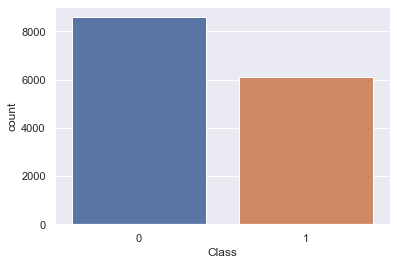

In [12]:
print( df4['Class'].value_counts( normalize=True ).map( "{:.2%}".format ) )

sns.countplot( x=df4['Class'] );

## 4.2. Correlations

Next, ...

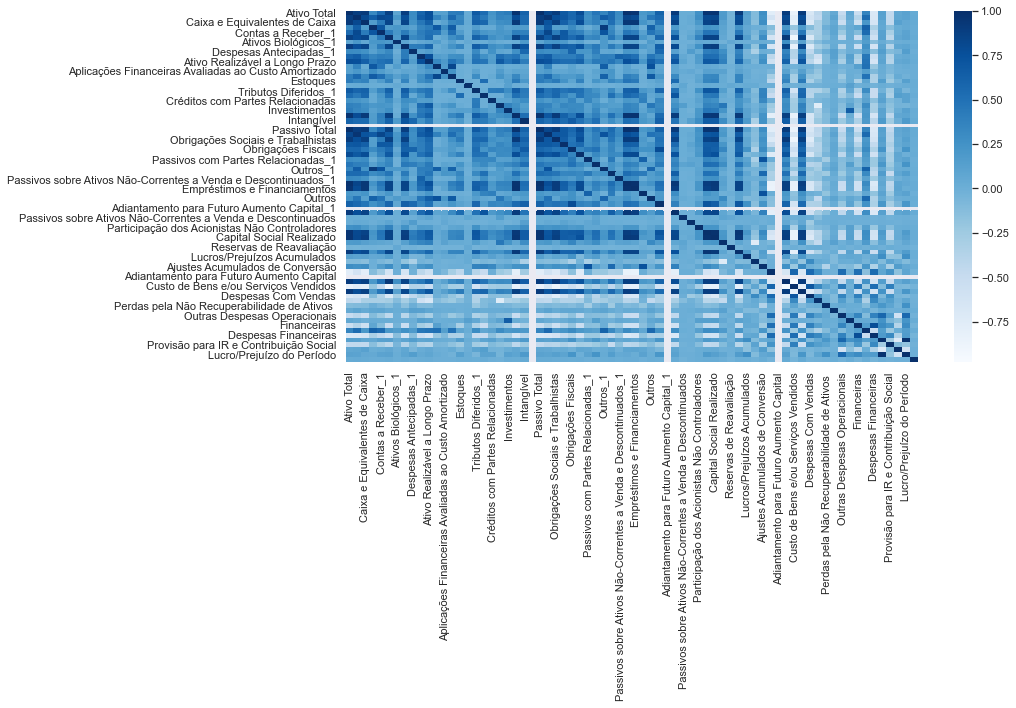

In [9]:
# Plot correlations
correlations = df4.corr()

fig, ax = plt.subplots( figsize=( 15, 10 ) )
sns.heatmap( correlations, cmap="Blues", ax=ax )
plt.tight_layout()

# 5.0. Data Preparation

in this section we will prepare the data so that it can be submitted to classification models. First, we will transform all indicators into percentage changes, similar to what we did with quotes. However, let's look backwards and see what the percentage change of an indicator has been from the previous quarter to the current one. We will do this for every quarter. The idea is to verify whether the increase or decrease of an indicator from the previous quarter to the current one can influence the appreciation or devaluation of the share price for the next quarter. In our case, we will see if the stock will appreciate more than 3% by the next quarter.

Later, we will scale the data to improve the overall performance of most of our models.

In [12]:
df5 = df4.copy()

## 5.1.  Transform indicators into percentage changes

In [13]:
df5 = transform_to_percentage_changes( df5 )

AALR3
0
ABEV3
1
ADHM3
2
AELP3
3
AFLT3
4
AGRO3
5
AHEB3
6
AHEB5
7
AHEB6
8
ALPA3
9
ALPA4
10
ALSO3
11
ALUP11
12
ALUP3
13
ALUP4
14
AMAR3
15
AMER3
16
ANIM3
17
APER3
18
ARZZ3
19
ATMP3
20
ATOM3
21
AZEV3
22
AZEV4
23
AZUL4
24
B3SA3
25
BAHI3
26
BALM3
27
BALM4
28
BAUH4
29
BBRK3
30
BBSE3
31
BDLL3
32
BDLL4
33
BEEF3
34
BHGR3
35
BIOM3
36
BKBR3
37
BLUT3
38
BLUT4
39
BMKS3
40
BOBR3
41
BOBR4
42
BPHA3
43
BRAP3
44
BRAP4
45
BRFS3
46
BRGE11
47
BRGE12
48
BRGE3
49
BRGE5
50
BRGE6
51
BRGE8
52
BRKM3
53
BRKM5
54
BRKM6
55
BRML3
56
BRPR3
57
CALI3
58
CALI4
59
CAMB3
60
CAMB4
61
CAML3
62
CARD3
63
CASN3
64
CBEE3
65
CBMA3
66
CBMA4
67
CCRO3
68
CEAB3
69
CEDO3
70
CEDO4
71
CEEB3
72
CEEB5
73
CEED3
74
CEED4
75
CEGR3
76
CEPE3
77
CEPE5
78
CEPE6
79
CESP3
80
CESP5
81
CESP6
82
CGAS3
83
CGRA3
84
CGRA4
85
CIEL3
86
CLSC3
87
CLSC4
88
CMIG3
89
CMIG4
90
COCE3
91
COCE5
92
COCE6
93
COGN3
94
CORR3
95
CORR4
96
CPFE3
97
CPLE3
98
CPLE5
99
CPLE6
100
CRDE3
101
CREM3
102
CRFB3
103
CRPG3
104
CRPG5
105
CRPG6
106
CSAN3
107
CSMG3
108
CSNA3
109
CSRN3
1

In [4]:
df5 = pd.read_csv( 'Data/df5.csv' )
df5.head()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Company,Class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AALR3,1
1,0.024169,-0.223037,-0.664194,-1.0,0.068190,-0.026443,0.0,0.358131,0.0,0.261700,0.091326,-0.006847,0.0,0.019037,0.0,0.0,0.463530,0.0,-0.144051,0.025059,0.179378,0.092226,0.101708,0.0,0.024169,0.061031,0.041550,-0.185468,0.231564,0.029226,0.0,0.0,0.394601,0.0,0.0,0.027630,-0.090771,-0.197952,0.265735,5.991689,0.0,-0.003432,0.0,0.0,0.082692,0.007929,0.000543,0.007595,0.0,0.0,0.323747,0.0,0.0,-1.000000,0.0,0.001162,-0.074818,-0.139757,0.0,0.308681,0.0,0.0,-1.184873,0.218048,0.449294,1.0,-1.0,2.183673,0.631670,-0.861458,-0.639973,AALR3,1
2,0.023534,0.066760,-0.043921,0.0,0.057865,-0.072967,0.0,0.264225,0.0,0.115816,-0.015497,-0.054446,0.0,-1.000000,0.0,0.0,0.040488,0.0,0.186017,-0.055666,-0.121929,0.060094,0.002347,0.0,0.023534,0.097474,0.044155,0.167984,0.207228,0.102094,0.0,0.0,-0.000626,0.0,0.0,-0.045220,-0.028715,-1.000000,-0.047523,0.157837,0.0,-0.103689,0.0,0.0,0.011613,0.029959,0.055539,-0.001639,0.0,0.0,0.327155,0.0,0.0,0.192094,0.0,0.042919,-0.009409,0.123024,0.0,-0.053433,0.0,0.0,0.273629,-0.000865,-1.246144,0.0,0.0,-0.346352,0.694535,-1.956710,-0.316626,AALR3,0
3,0.016449,0.050239,-0.006822,0.0,0.071552,0.037275,0.0,0.083896,0.0,-0.044013,0.036522,0.022247,0.0,0.000000,0.0,0.0,0.046768,0.0,0.085861,0.025343,0.173833,0.000478,0.003006,0.0,0.016449,0.088172,0.113525,0.096737,-0.016095,0.164371,0.0,0.0,-0.090438,0.0,0.0,-0.034449,-0.079832,1.000000,-0.004229,0.142231,0.0,-0.032049,0.0,0.0,0.056136,0.009883,0.000184,0.003788,0.0,1.0,1.000000,0.0,0.0,-0.508155,0.0,0.082354,-0.108907,0.025302,0.0,0.036938,0.0,0.0,0.696087,0.112810,0.155875,0.0,0.0,0.893641,-1.094416,1.015220,1.576884,AALR3,0
4,-0.010074,-0.066993,0.802878,1.0,-0.223995,-0.222798,0.0,-0.161529,0.0,0.068761,0.046340,-0.324799,0.0,0.000000,0.0,0.0,0.255386,0.0,0.119774,-0.047383,-0.059937,-0.009709,-0.005784,0.0,-0.010074,-0.293766,0.054601,0.008892,-0.550974,-0

In [14]:
# Delete Nan values
df5.dropna( inplace=True )

## 5.2. Rescaling

In [15]:
df5 = rescaling( df5 )

# 6.0. Feature Selection

In [16]:
df6 = df5.copy()

## 6.1. Finding the best features

In [19]:
# let's train a decision tree and get the most important features of it
model = ExtraTreesClassifier( random_state=1 )
X = df6.drop( ['Class', 'Company'], axis=1 )
y = df6['Class']
model.fit( X, y )

important_features = pd.DataFrame( model.feature_importances_, X.columns ).sort_values( by=0, ascending=False )
top10 = list( important_features.index )[:10]

top10.append( 'Class' )
df6 = df6[top10]

df6.head()

KeyError: "['Company'] not found in axis"

## 6.2. Split dataframe into training and test

In [9]:
X = df6.drop( 'Class', axis=1 )
y = df6['Class']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=13 )

# 7.0. Machine Learning Modeling

Logistic Regression, Decision Tree, K-Nearest Neighbors, Naive Bayes and Multilayer Perceptron

## 7.1. Baseline

Model: Dummy
              precision    recall  f1-score   support

Not reliable       0.58      0.59      0.58      2434
    Reliable       0.44      0.43      0.44      1846

    accuracy                           0.52      4280
   macro avg       0.51      0.51      0.51      4280
weighted avg       0.52      0.52      0.52      4280



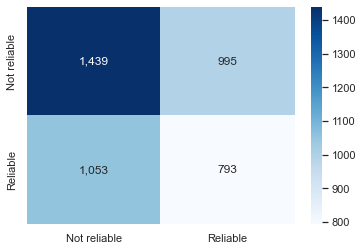

In [10]:
# Hold-out
dummy = DummyClassifier( strategy='stratified', random_state=13 )
dummy.fit( X_train, y_train )
dummy_pred = dummy.predict( X_test )

ml_metrics( y_test, dummy_pred, "Dummy" )

In [11]:
# Cross Validation
dummy = DummyClassifier( strategy='stratified', random_state=13 )

dummy_cv = cross_validation( dummy, X_train, y_train, 'Dummy' )
dummy_cv

,Model,Accuracy,Precision,Recall,F1
0,Dummy,0.51+/-0.01,0.42+/-0.01,0.41+/-0.01,0.41+/-0.01


## 7.2. Logistic Regression

Model: Logistic Regression
              precision    recall  f1-score   support

Not reliable       0.57      1.00      0.73      2434
    Reliable       0.77      0.01      0.01      1846

    accuracy                           0.57      4280
   macro avg       0.67      0.50      0.37      4280
weighted avg       0.66      0.57      0.42      4280



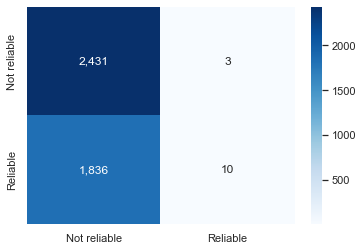

In [12]:
lr = LogisticRegression( random_state=13 )
lr.fit( X_train, y_train )
lr_pred = lr.predict( X_test )

ml_metrics( y_test, lr_pred, 'Logistic Regression' )

In [13]:
# Cross Validation
lr = LogisticRegression( random_state=13 )

lr_cv = cross_validation( lr, X_train, y_train, 'Logistic Regression' )
lr_cv

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.58+/-0.0,0.61+/-0.1,0.01+/-0.0,0.01+/-0.01


## 7.3. Decision Tree

Model: Decision Tree
              precision    recall  f1-score   support

Not reliable       0.64      0.68      0.66      2434
    Reliable       0.54      0.51      0.52      1846

    accuracy                           0.60      4280
   macro avg       0.59      0.59      0.59      4280
weighted avg       0.60      0.60      0.60      4280



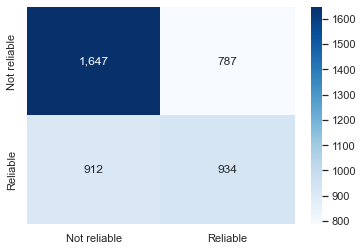

In [14]:
dt = DecisionTreeClassifier( random_state=13 )
dt.fit( X_train, y_train )
dt_prev = dt.predict( X_test )
ml_metrics( y_test, dt_prev, 'Decision Tree' )

In [15]:
# Cross Validation
dt = DecisionTreeClassifier( random_state=13 )
dt_cv = cross_validation( dt, X_train, y_train, 'Decision Tree' )
dt_cv

,Model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.59+/-0.01,0.5+/-0.01,0.48+/-0.01,0.49+/-0.01


## 7.4. K-Nearest Neighbors

Model: K-Nearest Neighbors
              precision    recall  f1-score   support

Not reliable       0.62      0.68      0.64      2434
    Reliable       0.51      0.44      0.47      1846

    accuracy                           0.58      4280
   macro avg       0.56      0.56      0.56      4280
weighted avg       0.57      0.58      0.57      4280



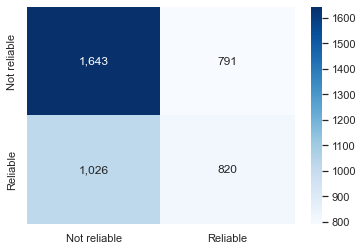

In [16]:
knn = KNeighborsClassifier()
knn.fit( X_train, y_train )
knn_prev = knn.predict( X_test )
ml_metrics( y_test, knn_prev, "K-Nearest Neighbors" )

In [17]:
# Cross Validation
knn = KNeighborsClassifier()
knn_cv = cross_validation( knn, X_train, y_train, "K-Nearest Neighbors" )
knn_cv

,Model,Accuracy,Precision,Recall,F1
0,K-Nearest Neighbors,0.56+/-0.01,0.48+/-0.01,0.42+/-0.01,0.45+/-0.0


## 7.5. Naive Bayes

Model: Naive Bayes
              precision    recall  f1-score   support

Not reliable       0.68      0.01      0.01      2434
    Reliable       0.43      1.00      0.60      1846

    accuracy                           0.43      4280
   macro avg       0.56      0.50      0.31      4280
weighted avg       0.57      0.43      0.27      4280



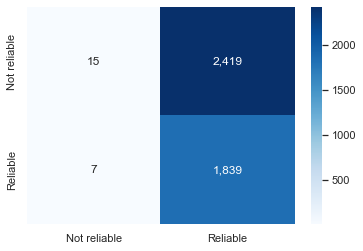

In [18]:
nb = GaussianNB()
nb.fit( X_train, y_train )
nb_pred = nb.predict( X_test )
ml_metrics( y_test, nb_pred, "Naive Bayes" )

In [19]:
# Cross Validation
nb = GaussianNB()
nb_cv = cross_validation( nb, X_train, y_train, "Naive Bayes" )
nb_cv

,Model,Accuracy,Precision,Recall,F1
0,Naive Bayes,0.45+/-0.06,0.41+/-0.02,0.8+/-0.39,0.48+/-0.23


## 7.6. Multilayer Perceptron

Model: Multilayer Perceptron
              precision    recall  f1-score   support

Not reliable       0.57      0.99      0.72      2434
    Reliable       0.56      0.02      0.04      1846

    accuracy                           0.57      4280
   macro avg       0.56      0.50      0.38      4280
weighted avg       0.57      0.57      0.43      4280



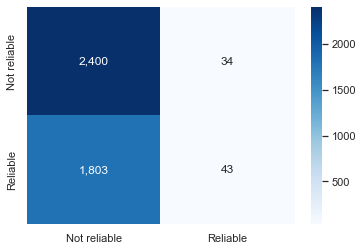

In [20]:
mlp = MLPClassifier( random_state=13 )
mlp.fit( X_train, y_train )
mlp_pred = mlp.predict( X_test )
ml_metrics( y_test, mlp_pred, "Multilayer Perceptron" )

In [21]:
# Cross Validation
mlp = MLPClassifier( random_state=13 )
mlp_cv = cross_validation( mlp, X_train, y_train, 'Multilayer Perceptron' )
mlp_cv

,Model,Accuracy,Precision,Recall,F1
0,Multilayer Perceptron,0.59+/-0.0,0.55+/-0.05,0.04+/-0.01,0.08+/-0.02


## 7.7. Random Forest

Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.65      0.77      0.71      2434
    Reliable       0.60      0.46      0.52      1846

    accuracy                           0.64      4280
   macro avg       0.63      0.61      0.61      4280
weighted avg       0.63      0.64      0.63      4280



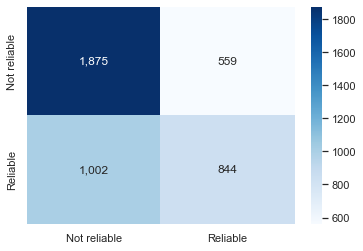

In [23]:
rf = RandomForestClassifier( random_state=13 )
rf.fit( X_train, y_train )
rf_pred = rf.predict( X_test )
ml_metrics( y_test, rf_pred, 'Random Forest')

In [24]:
# Cross Validation
rf = RandomForestClassifier( random_state=13 )
rf_cv = cross_validation( rf, X_train, y_train, 'Random Forest' )
rf_cv

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.62+/-0.01,0.56+/-0.01,0.42+/-0.02,0.48+/-0.01


## 7.8. Compare Model Performance

In [25]:
modeling_result = pd.concat( [dummy_cv, lr_cv, dt_cv, knn_cv, nb_cv, mlp_cv, rf_cv] )
modeling_result.sort_values( 'Precision', ascending=False ).reset_index( drop=True )

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.58+/-0.0,0.61+/-0.1,0.01+/-0.0,0.01+/-0.01
1,Random Forest,0.62+/-0.01,0.56+/-0.01,0.42+/-0.02,0.48+/-0.01
2,Multilayer Perceptron,0.59+/-0.0,0.55+/-0.05,0.04+/-0.01,0.08+/-0.02
3,Decision Tree,0.59+/-0.01,0.5+/-0.01,0.48+/-0.01,0.49+/-0.01
4,K-Nearest Neighbors,0.56+/-0.01,0.48+/-0.01,0.42+/-0.01,0.45+/-0.0
5,Dummy,0.51+/-0.01,0.42+/-0.01,0.41+/-0.01,0.41+/-0.01
6,Naive Bayes,0.45+/-0.06,0.41+/-0.02,0.8+/-0.39,0.48+/-0.23


# 8.0. Hyperparameter Fine Tuning

In [10]:
params = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False] }


precision2_score = make_scorer( precision_score, labels=[1], average='macro' )

search = RandomizedSearchCV(
        estimator = RandomForestClassifier( random_state=13 ),
        param_distributions=params,
        n_iter=10,
        scoring=precision2_score,
        n_jobs=-1,
        random_state=13
)

result = search.fit( X_train, y_train )
print( 'Done!' )

Done!


Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.65      0.82      0.72      2434
    Reliable       0.63      0.41      0.50      1846

    accuracy                           0.64      4280
   macro avg       0.64      0.61      0.61      4280
weighted avg       0.64      0.64      0.63      4280



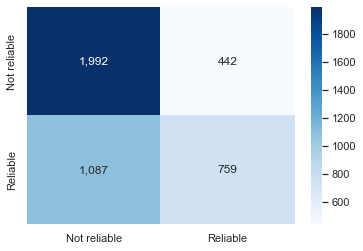

In [11]:
tuned_model = result.best_estimator_
predictions = tuned_model.predict( X_test )
ml_metrics( y_test, predictions, "Random Forest" )

# 9.0. Machine Learning Performance

In [12]:
# Importing the data to test the model
df_test = pd.read_csv( 'Data/Fundamentals_test.csv' )

df_test.head()

,Ativo Total,Ativo Circulante,Caixa e Equivalentes de Caixa,Aplicações Financeiras,Contas a Receber_1,Estoques_1,Ativos Biológicos_1,Tributos a Recuperar,Despesas Antecipadas_1,Outros Ativos Circulantes,Ativo Realizável a Longo Prazo,Aplicações Financeiras Avaliadas a Valor Justo,Aplicações Financeiras Avaliadas ao Custo Amortizado,Contas a Receber,Estoques,Ativos Biológicos,Tributos Diferidos_1,Despesas Antecipadas,Créditos com Partes Relacionadas,Outros Ativos Não Circulantes,Investimentos,Imobilizado,Intangível,Diferido,Passivo Total,Passivo Circulante,Obrigações Sociais e Trabalhistas,Fornecedores,Obrigações Fiscais,Empréstimos e Financiamentos_1,Passivos com Partes Relacionadas_1,Dividendos e JCP a Pagar,Outros_1,Provisões_1,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados_1,Passivo Não Circulante,Empréstimos e Financiamentos,Passivos com Partes Relacionadas,Outros,Tributos Diferidos,Adiantamento para Futuro Aumento Capital_1,Provisões,Passivos sobre Ativos Não-Correntes a Venda e Descontinuados,Lucros e Receitas a Apropriar,Participação dos Acionistas Não Controladores,Patrimônio Líquido,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,Resultado da Equivalência Patrimonial,Financeiras,Receitas Financeiras,Despesas Financeiras,Resultado Antes Tributação/Participações,Provisão para IR e Contribuição Social,IR Diferido,Lucro/Prejuízo do Período,Adj Close,Company,Perc,Class
0,2.569669e+06,5.804370e+05,2.286540e+05,0.000,251004.000,9867.000,0.0,47599.000,0.000,43313.000,5.056020e+05,2760.0,0.0,0.000,0.0,0.0,0.0,146420.992,0.000,17712.0,10986.000,5.063370e+05,9.663070e+05,0,2.569669e+06,5.224990e+05,45875.000,7.515100e+04,29703.000,276504.000,0.000,3577.000,91689.000,0.000,0.0,8.108030e+05,515145.984,121.0,2.333340e+05,20912.000,0,41290.000,0.0,0.0,35351.000,1.201016e+06,6.124120e+05,6.231010e+05,0.0,0.000000e+00,-34422.000,0.000000e+00,0.0,-75.0,0,2.851800e+05,-200362.000,84818.000,0.00,-57573.000,0.0,0.000,2296.0,3369.0,-17679.000,0.000,0.000,15231.000,-7160.000,4459.000,10119.000,9.000000,AALR3,0.306667,1
1,2.632144e+06,5.852940e+05,2.174780e+05,0.000,267706.000,8614.000,0.0,53959.000,0.000,37537.000,5.595530e+05,2760.0,0.0,0.000,0.0,0.0,0.0,147868.000,0.000,17595.0,10121.000,5.079780e+05,9.691980e+05,0,2.632144e+06,4.857930e+05,55479.000,7.584300e+04,31682.000,237114.000,0.000,3577.000,82098.000,0.000,0.0,9.029610e+05,549067.008,2972.0,2.895550e+05,20141.000,0,41226.000,0.0,0.0,31212.000,1.212178e+06,6.124120e+05,6.237580e+05,0.0,0.000000e+00,-23992.000,0.000000e+00,0.0,0.0,0,2.832120e+05,-194614.000,88598.000,0.00,-67465.000,0.0,0.000,10178.0,2315.0,-18695.000,0.000,0.000,14931.000,-7377.000,4133.000,10430.000,11.760000,AALR3,-0.017857,0
2,1.334178e+08,3.705986e+07,1.728607e+07,2049628.032,3357889.024,9698229.248,0.0,3005978.112,360712.000,1301357.056,1.836991e+07,0.0,0.0,218335.008,0.0,0.0,0.0,5926253.056,344566.016,0.0,341043.008,2.667690e+07,5.097011e+07,0,1.334178e+08,3.188072e+07,1287634.048,1.943734e+07,3628035.072,2598908.928,1378932.992,1325042.048,2086182.016,138648.992,0.0,1.790672e+07,2428251.904,0.0,1.159367e+07,3439365.888,0,445428.992,0.0,0.0,1586272.000,8.204412e+07,5.797387e+07,5.497776e+07,0.0,2.592006e+07,3220705.024,-6.004827e+07,0.0,0.0,0,1.663976e+07,-7945330.176,8694430.720,-3574632.96,-1234059.008,0.0,254400.992,-147886.0,-12546.0,-1064300.032,380095.008,-1444395.008,2915407.872,-515992.000,333895.008,2625412.096,14.715697,ABEV3,0.116416,1
3,1.244401e+08,3.270567e+07,1.326935e+07,1245607.040,3702152.960,9583373.312,0.0,2865117.952,478539.008,156

In [15]:
# Filtering Data
df_test = df_test.loc[ ( df_test.Company != 'MMAQ3' ) & ( df_test['Adj Close'] > 0 ) ]
df_test = df_test.drop( ['Adj Close', 'Perc'], axis=1 )

# Find Percentage Changes
df_test = transform_to_percentage_changes( df_test )

# Delete Nan values
df_test.dropna( inplace=True )

# Rescaling
df_test = rescaling( df_test )

# Selecting the best features
df_test = df_test[top10]

# Separating the features from the target variable
X = df_test.drop( 'Class', axis=1 )
y = df_test['Class']

Model: Random Forest
              precision    recall  f1-score   support

Not reliable       0.84      0.97      0.90       347
    Reliable       0.00      0.00      0.00        64

    accuracy                           0.82       411
   macro avg       0.42      0.48      0.45       411
weighted avg       0.71      0.82      0.76       411



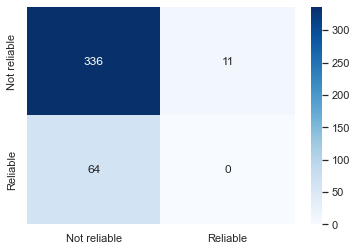

In [18]:
# Getting the predictions
test_prev = tuned_model.predict( X )

# Performance
ml_metrics( y, test_prev, "Random Forest" )

# 10.0. Deploy Model to Production

# 11.0. Conclusions